In [24]:
import os
from PIL import Image
import torch

from ip_adapter import ConceptrolIPAdapterPlus, IPAdapterPlus
from ip_adapter.custom_pipelines import StableDiffusionCustomPipeline

In [2]:
def image_grid(imgs, rows, cols, res=256):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*res, rows*res))

    for i, img in enumerate(imgs):
        grid.paste(img.resize((res, res)), box=(i%cols*res, i//cols*res))
    return grid

In [3]:
base_model_path = "SG161222/Realistic_Vision_V5.1_noVAE"
ip_adapter_path = "../human-centric-adapter/models/ip-adapter-plus_sd15.bin"
image_encoder_path = "../human-centric-adapter/models/image_encoder/"
device = "cuda"

In [25]:
pipe = StableDiffusionCustomPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    feature_extractor=None,
    safety_checker=None
)
conceptrol_pipe = ConceptrolIPAdapterPlus(pipe, image_encoder_path, ip_adapter_path, device, num_tokens=16, global_masking=True, adaptive_scale_mask=True)
ip_pipe = IPAdapterPlus(pipe, image_encoder_path, ip_adapter_path, device, num_tokens=16)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

down_blocks.0.attentions.0.transformer_blocks.0.attn2.processor
down_blocks.0.attentions.1.transformer_blocks.0.attn2.processor
down_blocks.1.attentions.0.transformer_blocks.0.attn2.processor
down_blocks.1.attentions.1.transformer_blocks.0.attn2.processor
down_blocks.2.attentions.0.transformer_blocks.0.attn2.processor
down_blocks.2.attentions.1.transformer_blocks.0.attn2.processor
up_blocks.1.attentions.0.transformer_blocks.0.attn2.processor
up_blocks.1.attentions.1.transformer_blocks.0.attn2.processor
up_blocks.1.attentions.2.transformer_blocks.0.attn2.processor
up_blocks.2.attentions.0.transformer_blocks.0.attn2.processor
up_blocks.2.attentions.1.transformer_blocks.0.attn2.processor
up_blocks.2.attentions.2.transformer_blocks.0.attn2.processor
up_blocks.3.attentions.0.transformer_blocks.0.attn2.processor
up_blocks.3.attentions.1.transformer_blocks.0.attn2.processor
up_blocks.3.attentions.2.transformer_blocks.0.attn2.processor
mid_block.attentions.0.transformer_blocks.0.attn2.processo

/home/qiyuan/Conceptrol/ip_adapter/ip_adapter.py:297: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")
/home/qiyuan/Co

['hat', 'man', 'avocado', 'bicycle', 'A young Asian male star']


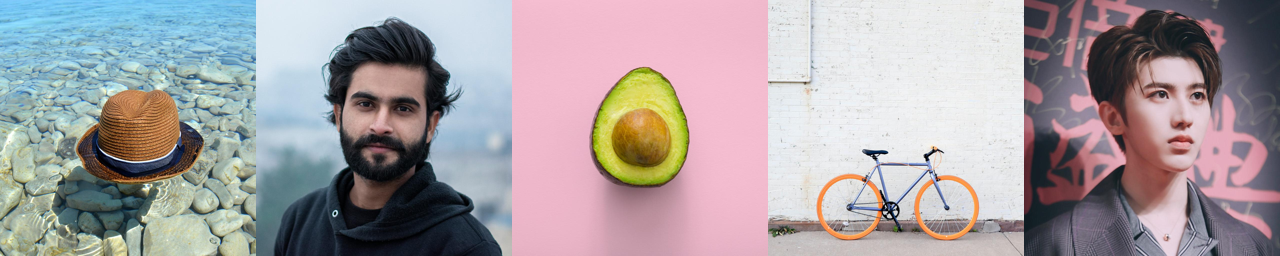

In [29]:
visual_specifications = [Image.open(f"demo_data/visual_specification/0{i}.png") for i in range(len(os.listdir("demo_data/visual_specification")))]
textual_concepts = [open(f"demo_data/textual_concept/0{i}.txt").read() for i in range(len(os.listdir("demo_data/textual_concept")))]

print(textual_concepts)
image_grid(visual_specifications, 1, len(visual_specifications))

[(6, 7)]


  0%|          | 0/50 [00:00<?, ?it/s]

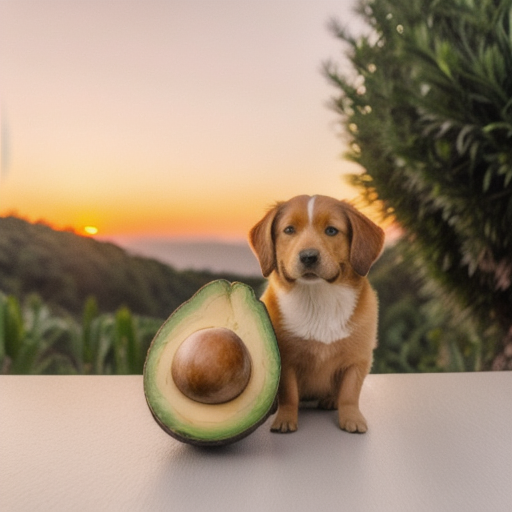

In [42]:
prompt = "A dog is with an avocado under sunset, high quality, best quality"
negative_prompt = "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"

images = []
texts = []
for subject in textual_concepts:
    if subject in prompt:
        idx = textual_concepts.index(subject)
        images.append(visual_specifications[idx])
        texts.append(subject)

results = conceptrol_pipe.generate(prompt=prompt, pil_images=images, subjects=texts, num_samples=1, num_inference_steps=50,
                            scale=1.0, negative_prompt=negative_prompt, control_guidance_start=0.12, seed=42)
results[0]

  0%|          | 0/50 [00:00<?, ?it/s]

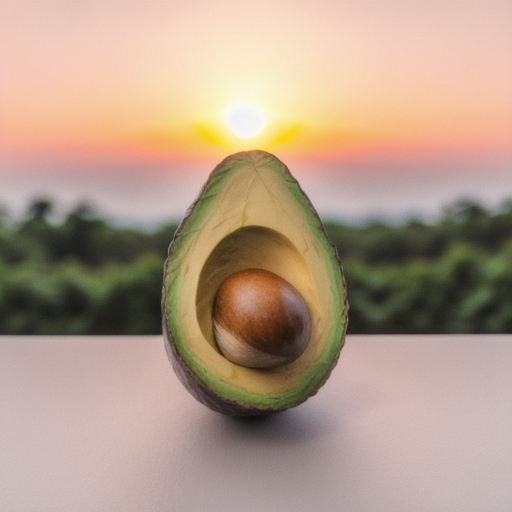

In [46]:
prompt = "A dog is with an avocado under sunset, high quality, best quality"
negative_prompt = "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"

images = []
texts = []
for subject in textual_concepts:
    if subject in prompt:
        idx = textual_concepts.index(subject)
        images.append(visual_specifications[idx])
        texts.append(subject)

results = ip_pipe.generate(prompt=prompt, pil_images=images, num_samples=1, num_inference_steps=50,
                            scale=0.5, negative_prompt=negative_prompt, control_guidance_start=0.0, seed=42)
results[0]

[(5, 6), (2, 3)]


  0%|          | 0/50 [00:00<?, ?it/s]

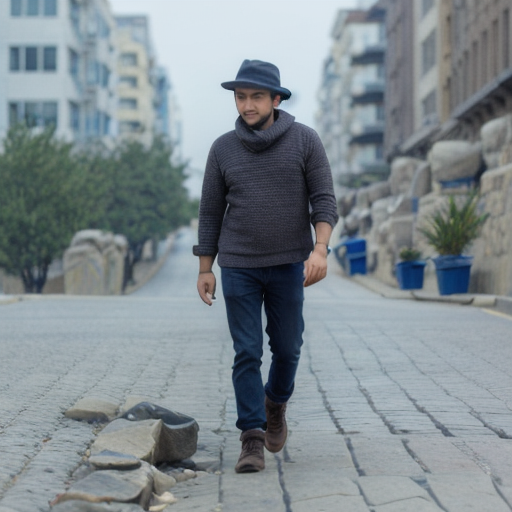

In [41]:
prompt = "A man wearing a hat walking on the street, high quality, best quality"
negative_prompt = "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"

images = []
texts = []
for subject in textual_concepts:
    if subject in prompt:
        idx = textual_concepts.index(subject)
        images.append(visual_specifications[idx])
        texts.append(subject)

results = conceptrol_pipe.generate(prompt=prompt, pil_images=images, subjects=texts, num_samples=1, num_inference_steps=50,
                            scale=1.5, negative_prompt=negative_prompt, control_guidance_start=0.2, seed=42)
results[0]

[(2, 3), (6, 7)]


  0%|          | 0/50 [00:00<?, ?it/s]

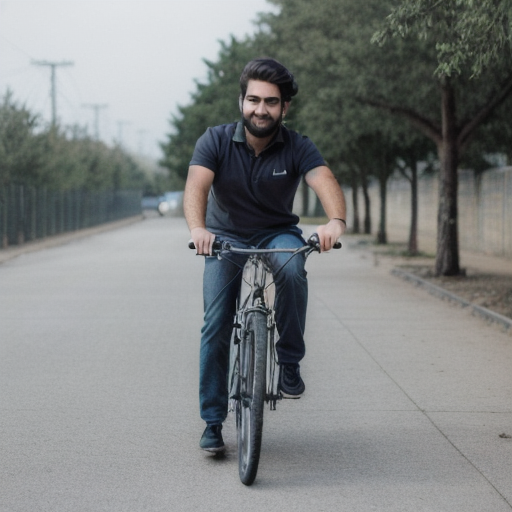

In [31]:
prompt = "A man is riding a bicycle, high quality, best quality"
negative_prompt = "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"

images = []
texts = []
for subject in textual_concepts:
    if subject in prompt:
        idx = textual_concepts.index(subject)
        images.append(visual_specifications[idx])
        texts.append(subject)

results = conceptrol_pipe.generate(prompt=prompt, pil_images=images, subjects=texts, num_samples=1, num_inference_steps=50,
                            scale=1.5, negative_prompt=negative_prompt, control_guidance_start=0.2, seed=42)
results[0]